<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo" width=128px>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.2 March 2020  
Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

## APACHE II
The Acute Physiology and Chronic Health Evaluation (APACHE) APACHE II is a severity-of-ilness scoring and mortality predicting system (Knaus et al., 1985) based on the first 24 hours of ICU admission. It was superseded by APACHE IV (Zimmerman et al., 2006), though it continued to be in use for historical comparison for quite some time.

The scoring system uses physiologic variables (part A), Age point (part B) and Chronic Health Points (part C). The Chronic Health Points-calculation has currently not been implemented because they have not been documented consistently. The code performs some data cleanup and calculates the score for all patients in the database.

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')

#uncomment for high resolution (print-ready) versions
#plt.rcParams["figure.dpi"] = 288
#plt.rcParams["figure.figsize"] = [16, 12]
#plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../../config.ini'):
    config.read('../../config.ini')
else:
    config.read('../../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

In [4]:
#loads the admissions table for stratification on admission unit 
sql = """
SELECT * FROM admissions;
"""
admissions = pd.read_sql(sql,con)

In [5]:
#No. patients
no_patients_total = admissions.patientid.nunique()
no_patients_ICU = admissions[admissions['location'].str.contains('IC')].patientid.nunique()
no_patients_MCU = admissions[admissions['location'].str.contains('^MC$')].patientid.nunique()

#No. admissions
no_admissions_total = admissions.admissionid.nunique()
no_admissions_ICU = admissions[admissions['location'].str.contains('IC')].admissionid.nunique()
no_admissions_MCU = admissions[admissions['location'].str.contains('^MC$')].admissionid.nunique()

In [6]:
#loads the dictionary from the amsterdamumcdb package for fast lookup
dictionary = amsterdamumcdb.get_dictionary()
listitems_itemids = dictionary[dictionary['table'] == 'listitems'][['itemid','item','item_en','valueid','value','count','count_validated']]
numericitems_itemids = dictionary[dictionary['table'] == 'numericitems'][['itemid','item','item_en','unitid','unit','count','count','count_validated']]
freetextitems_itemids = dictionary[dictionary['table'] == 'freetextitems'][['itemid','item','item_en','unitid','unit','count','count','count_validated']]

### A: Acute Physiology Score (APS)

#### Temperature - rectal 
Any temperature is used in for Table 1

In [7]:
#Temperature - rectal 
#Any temperature is used in for Table 1
numericitems_itemids[numericitems_itemids['item'].str.contains('temp', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
393,16639,MCA_Temperatuur,NaN,59.0,°C,21,21,21.0
419,14481,RA_Temperatuur,NaN,59.0,°C,13,13,13.0
1152,13067,A_Temperatuur,NaN,59.0,°C,200,200,200.0
1272,12458,TempVerwarmer,NaN,59.0,°C,66552,66552,0.0
1275,7905,TempVerwarmer ingesteld,NaN,59.0,°C,68576,68576,57651.0
1308,14852,MFT_Temperatuur (ingesteld),NaN,59.0,°C,1804527,1804527,88860.0
2474,8658,Temp Bloed,blood temperature,59.0,°C,1999754,1999754,196894.0
2475,8659,Temperatuur Perifeer 2,peripheral temperature,59.0,°C,27999,27999,27082.0
2476,8662,Temperatuur Perifeer 1,peripheral temperature,59.0,°C,172138,172138,168297.0
2496,13058,Temp Rectaal,rectal temperature,59.0,°C,387259,387259,34195.0


In [8]:
sql_temperature = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    8658, --Temp Bloed
    8659, --Temperatuur Perifeer 2
    8662, --Temperatuur Perifeer 1
    13058, --Temp Rectaal
    13059, --Temp Lies
    13060, --Temp Axillair
    13061, --Temp Oraal
    13062, --Temp Oor
    13063, --Temp Huid
    13952, --Temp Blaas
    16110 --Temp Oesophagus
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""

temperature = pd.read_sql(sql_temperature, con)
temperature.head()

,admissionid,itemid,item,value,validated,time
0,0,8658,Temp Bloed,35.9,True,342
1,1,8658,Temp Bloed,35.6,True,50
2,1,8658,Temp Bloed,35.8,True,110
3,1,13058,Temp Rectaal,35.7,True,50
4,0,13063,Temp Huid,28.6,True,342


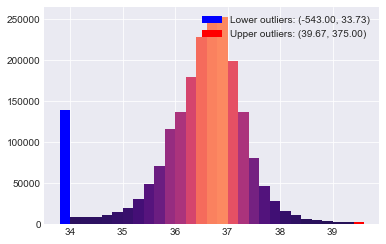

In [9]:
amsterdamumcdb.outliers_histogram(data=temperature['value'].dropna()).show()

In [10]:
#cleanup temperatures
#assumes temperatures  > 100 have been entered without a decimal separator
temperature.loc[temperature['value'] > 100, 'value'] = temperature['value']/10

In [11]:
#remove extreme outliers, most likely data entry errors or measurement errors (i.e. ambient temperature due to displaced
# sensor)
temperature.loc[(temperature['value'] > 43), 'value'] = np.NaN
temperature.loc[(temperature['value'] <= 30), 'value'] = np.NaN
temperature = temperature.dropna()

In [12]:
#calculate the temperature score
temperature['a2_temperature_score'] = 0
temperature.loc[(temperature['value'] >= 41), 'a2_temperature_score'] = 4
temperature.loc[(temperature['value'] >= 39) & (temperature['value'] < 41), 'a2_temperature_score'] = 3
temperature.loc[(temperature['value'] >= 38.5) & (temperature['value'] < 39), 'a2_temperature_score'] = 1
temperature.loc[(temperature['value'] >= 36) & (temperature['value'] < 38.5), 'a2_temperature_score'] = 0
temperature.loc[(temperature['value'] >= 34) & (temperature['value'] < 36), 'a2_temperature_score'] = 1
temperature.loc[(temperature['value'] >= 32) & (temperature['value'] < 34), 'a2_temperature_score'] = 2
temperature.loc[(temperature['value'] >= 30) & (temperature['value'] < 32), 'a2_temperature_score'] = 3
temperature.loc[(temperature['value'] < 30), 'a2_temperature_score'] = 4

#### <a id='map'></a>APACHE II: Mean arterial pressure (mm Hg)

In [13]:
#-- Mean arterial pressure --mm Hg
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:ABP|bloeddruk).*gemiddeld', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2342,6642,ABP gemiddeld,invasive mean arterial pressure,173.0,mmHg,33352770,33352770,2109165.0
2346,6679,Niet invasieve bloeddruk gemiddeld,non-invasive mean arterial pressure,173.0,mmHg,190760,190760,122240.0
2441,8843,ABP gemiddeld II,invasive mean arterial pressure,173.0,mmHg,56028,56028,1817.0


In [14]:
sql_mean_abp = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6679, --Niet invasieve bloeddruk gemiddeld
    8843 --ABP gemiddeld II
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""

mean_abp = pd.read_sql(sql_mean_abp, con)
mean_abp.head()

,admissionid,itemid,item,value,validated,time
0,13575,6642,ABP gemiddeld,62.0,False,56
1,13574,6679,Niet invasieve bloeddruk gemiddeld,92.0,False,24
2,13574,6679,Niet invasieve bloeddruk gemiddeld,92.0,True,26
3,13574,6679,Niet invasieve bloeddruk gemiddeld,101.0,False,84
4,13574,6679,Niet invasieve bloeddruk gemiddeld,105.0,False,145


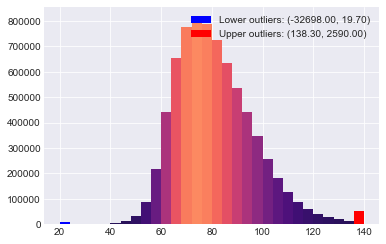

In [15]:
amsterdamumcdb.outliers_histogram(data=mean_abp['value'].dropna()).show()

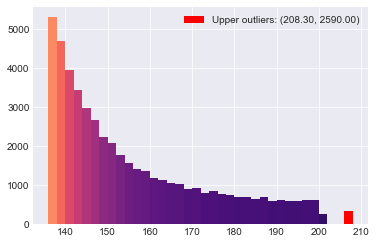

In [16]:
amsterdamumcdb.outliers_histogram(data=mean_abp.loc[mean_abp['value'] > 135, 'value']).show()

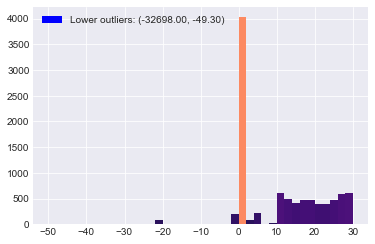

In [17]:
amsterdamumcdb.outliers_histogram(data=mean_abp.loc[mean_abp['value'] < 30, 'value']).show()

In [18]:
#remove extreme outliers, most likely data entry errors or measurement errors
mean_abp.loc[(mean_abp['value'] > 165), 'value'] = np.NaN
mean_abp.loc[(mean_abp['value'] <= 30), 'value'] = np.NaN
mean_abp = mean_abp.dropna()

In [19]:
#calculate the mean arterial pressure score
mean_abp['a2_mean_abp_score'] = 0
mean_abp.loc[(mean_abp['value'] >= 160), 'a2_mean_abp_score'] = 4
mean_abp.loc[(mean_abp['value'] >= 130) & (mean_abp['value'] < 160), 'a2_mean_abp_score'] = 3
mean_abp.loc[(mean_abp['value'] >= 110) & (mean_abp['value'] < 130), 'a2_mean_abp_score'] = 2
mean_abp.loc[(mean_abp['value'] >= 70) & (mean_abp['value'] < 110), 'a2_mean_abp_score'] = 0
mean_abp.loc[(mean_abp['value'] >= 50) & (mean_abp['value'] < 70), 'a2_mean_abp_score'] = 2
mean_abp.loc[(mean_abp['value'] < 50), 'a2_mean_abp_score'] = 4

#### APACHE II: Heart rate (ventricular response)

In [20]:
#Heart rate (ventricular response)
numericitems_itemids[numericitems_itemids['item'].str.contains('hartfreq', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
1164,13075,A_Hartfrequentie,NaN,15.0,/min,56,56,56.0
2358,6640,Hartfrequentie,heart rate,15.0,/min,37732398,37732398,2218626.0
7455,14055,PiCCO HF Hartfrequentie,PiCCO heart rate,15.0,/min,4559,4559,4330.0


In [21]:
sql_heart_rate = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6640 --Hartfrequentie
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""

heart_rate = pd.read_sql(sql_heart_rate, con)
heart_rate.head()

,admissionid,itemid,item,value,validated,time
0,13575,6640,Hartfrequentie,104.0,False,56
1,13575,6640,Hartfrequentie,99.0,True,116
2,13575,6640,Hartfrequentie,101.0,False,176
3,13575,6640,Hartfrequentie,97.0,True,236
4,13575,6640,Hartfrequentie,112.0,True,296


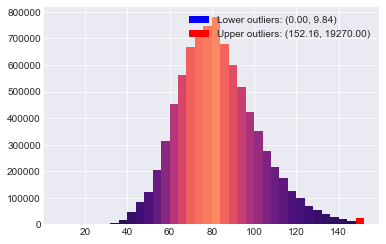

In [22]:
amsterdamumcdb.outliers_histogram(data=heart_rate['value'].dropna()).show()

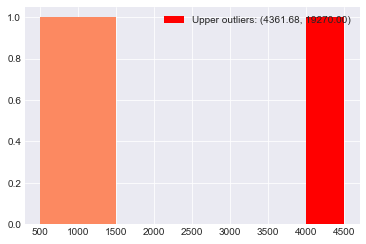

In [23]:
amsterdamumcdb.outliers_histogram(data=heart_rate.loc[heart_rate['value'] > 300, 'value']).show()

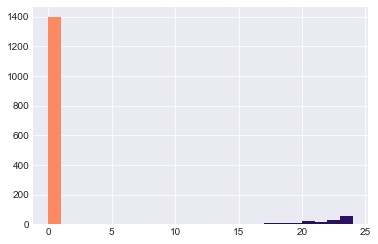

In [24]:
amsterdamumcdb.outliers_histogram(data=heart_rate.loc[heart_rate['value'] <25, 'value']).show()

In [25]:
#remove extreme outliers, most likely data entry errors or measurement errors
heart_rate.loc[(heart_rate['value'] > 300), 'value'] = np.NaN
heart_rate = heart_rate.dropna()

In [26]:
#calculate the heart rate score
heart_rate['a2_heart_rate_score'] = 0
heart_rate.loc[(heart_rate['value'] >= 180), 'a2_heart_rate_score'] = 4
heart_rate.loc[(heart_rate['value'] >= 140) & (heart_rate['value'] < 180), 'a2_heart_rate_score'] = 3
heart_rate.loc[(heart_rate['value'] >= 110) & (heart_rate['value'] < 140), 'a2_heart_rate_score'] = 2
heart_rate.loc[(heart_rate['value'] >= 70) & (heart_rate['value'] < 110), 'a2_heart_rate_score'] = 0
heart_rate.loc[(heart_rate['value'] >= 55) & (heart_rate['value'] < 70), 'a2_heart_rate_score'] = 2
heart_rate.loc[(heart_rate['value'] >= 40) & (heart_rate['value'] < 55), 'a2_heart_rate_score'] = 3
heart_rate.loc[(heart_rate['value'] < 40), 'a2_heart_rate_score'] = 4

#### APACHE II: Respiratory rate (non-ventilated or ventilated)

In [27]:
#Respiratory rate (non-ventilated or ventilated) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('adem.*freq|spont|adem', flags=re.IGNORECASE)][['itemid','item']]

,itemid,item
371,16613,MCA_Ademfrequentie
401,14455,RA_Ademfrequentie
1175,13092,A_Ademfrequentie
7828,12283,Adem Frequentie (Set)
7855,12294,SIMV ademcyclus (Set)
7868,12322,Adem Frequentie (Set) (2)
7894,8874,Ademfrequentie Monitor
7895,12266,Ademfreq.
7906,12303,SBI (Zwakke ademhalingsindex)
7914,12577,Ademfreq. Spontaan nieuw


In [28]:
sql_resp_rate = """
WITH resp_rate AS (
    SELECT 
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE 
            WHEN NOT n.registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (n.measuredat - a.admittedat)/(1000*60) AS time,
        ROW_NUMBER() OVER(
            PARTITION BY n.admissionid, n.measuredat
            ORDER BY 
                CASE itemid
                    WHEN 8873 THEN 1 --Ventilator measurements
                    WHEN 12266 THEN 2 --Ventilator measurements
                    ELSE 3  --Patient monitor measurements
                END
            ) AS priority
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        --Evita Parameters
        8873, --Ademfrequentie Evita: measurement by Evita ventilator, most accurate
        --7726, --Ademfrequentie Spontaan: measurement by Evita ventilator, spontaneous breaths/min, distiction not needed for 'actual' respiratory rate
        --9654, --Ademfrequentie Spontaan(2): measurement by 2nd simultaneously used Evita ventilator (very uncommon), spontaneous breaths/min, distiction not needed for 'actual' respiratory rate

        --Servo-i/Servo-u Parameters
        --12283, --Adem Frequentie (Set): setting on Servo-i/Servo-U ventilator, not needed for 'actual' respiratory rate
        --12322, --Adem Frequentie (Set) (2): setting on 2nd simultaneously used Servo-i/Servo-U ventilator (uncommon), not needed for 'actual' respiratory rate
        12266, --Ademfreq.: measurement by Servo-i/Servo-U ventilator, most accurate
        --12348, --Ademfreq.(2): measurement by 2nd simultaneously used Servo-i/Servo-U ventilator (uncommon), no additional information
        --12577 --Ademfreq. Spontaan nieuw --from Servo-i/Servo-U ventilator, spontaneous breaths/min, distiction not needed for 'actual' respiratory rate

        --Patient monitor
        8874 --Ademfrequentie Monitor: measurement by patient monitor using ECG-impedance, less accurate
        )
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
)
SELECT * FROM
resp_rate
WHERE priority = 1 --only retrieve most accurate measurement

"""
resp_rate = pd.read_sql(sql_resp_rate, con)
resp_rate.head()

,admissionid,itemid,item,value,validated,time,priority
0,0,12266,Ademfreq.,13.0,True,342,1
1,0,12266,Ademfreq.,13.0,True,372,1
2,0,12266,Ademfreq.,13.0,True,432,1
3,0,12266,Ademfreq.,13.0,True,492,1
4,0,12266,Ademfreq.,13.0,True,552,1


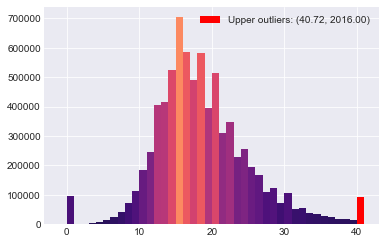

In [29]:
amsterdamumcdb.outliers_histogram(data=resp_rate['value'].dropna()).show() 

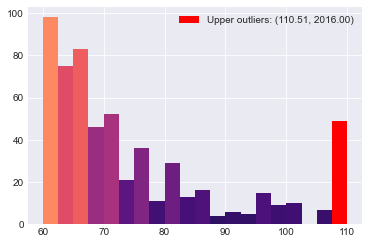

In [30]:
amsterdamumcdb.outliers_histogram(data=resp_rate.loc[resp_rate['value'] > 60, 'value'].dropna()).show()

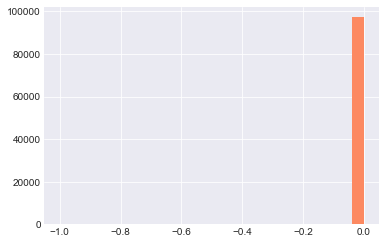

In [31]:
amsterdamumcdb.outliers_histogram(data=resp_rate.loc[resp_rate['value'] <= 0, 'value'].dropna()).show()

In [32]:
resp_rate.loc[(resp_rate['value'] <= 0) & (resp_rate['validated'] == True)]

,admissionid,itemid,item,value,validated,time,priority
735,4,8874,Ademfrequentie Monitor,0.0,True,768,1
795,4,8874,Ademfrequentie Monitor,0.0,True,828,1
855,4,8874,Ademfrequentie Monitor,0.0,True,888,1
2949,12,8873,Ademfrequentie Evita,0.0,True,15,1
2950,12,8874,Ademfrequentie Monitor,0.0,True,46,1
6021,18,8874,Ademfrequentie Monitor,0.0,True,513,1
6815,20,8874,Ademfrequentie Monitor,0.0,True,32,1
6840,21,8874,Ademfrequentie Monitor,0.0,True,189,1
8936,31,8874,Ademfrequentie Monitor,0.0,True,784,1
22168,66,8874,Ademfrequentie Monitor,0.0,True,4,1


In [33]:
#remove extreme outliers, most likely data entry errors or measurement errors
#specifically for the Evita ventilator '0' was given in 'standby'; additionally 0 is often reported by the patient monitor
resp_rate.loc[resp_rate['value'] > 60, 'value'] = np.NaN
resp_rate.loc[resp_rate['value'] <= 0, 'value'] = np.NaN
resp_rate = resp_rate.dropna()

In [34]:
#calculate the respiratory rate score
resp_rate['a2_resp_rate_score'] = 0
resp_rate.loc[(resp_rate['value'] >= 50), 'a2_resp_rate_score'] = 4
resp_rate.loc[(resp_rate['value'] >= 35) & (resp_rate['value'] < 50), 'a2_resp_rate_score'] = 3
resp_rate.loc[(resp_rate['value'] >= 25) & (resp_rate['value'] < 35), 'a2_resp_rate_score'] = 1
resp_rate.loc[(resp_rate['value'] >= 12) & (resp_rate['value'] < 25), 'a2_resp_rate_score'] = 0
resp_rate.loc[(resp_rate['value'] >= 10) & (resp_rate['value'] < 12), 'a2_resp_rate_score'] = 1
resp_rate.loc[(resp_rate['value'] >= 6) & (resp_rate['value'] < 10), 'a2_resp_rate_score'] = 2
resp_rate.loc[(resp_rate['value'] < 6), 'a2_resp_rate_score'] = 4

#### APACHE: Oxygenation: A-aDO, or PaO2 (mmHg)
- a. FiO2 >= 0.5 record A-aDO2
- b. FiO2 < 0.5 record only PaO2

In [35]:
#locate the specimen source for retrieving arterial blood gas samples
freetextitems_itemids[freetextitems_itemids['item'].str.contains('afname', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2893,11646,Afname (bloed),specimen source,NaN,NaN,515230,515230,515230.0
3279,11139,Afname (semen),NaN,NaN,NaN,1,1,1.0


In [36]:
sql_afname = """
SELECT DISTINCT itemid, item, value
FROM freetextitems
WHERE itemid = 11646 --Afname (bloed)
    AND value ILIKE '%art.%'
"""
afname = pd.read_sql(sql_afname,con)
afname

,itemid,item,value
0,11646,Afname (bloed),art.
1,11646,Afname (bloed),Art.
2,11646,Afname (bloed),ART.


In [37]:
#APACHE: Oxygenation: A-aDO, or PaO2 (mmHg) / FiO2 - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('FiO2|sO2|O2|zuurstof|CO2', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
381,16629,MCA_FiO2,NaN,191.0,Geen,1951,1951,1951.0
409,14471,RA_FiO2,NaN,191.0,Geen,76,76,76.0
1165,13076,A_FiO2,NaN,191.0,Geen,10817,10817,10817.0
1185,12534,SvO2 Vigilance,NaN,191.0,Geen,323,323,323.0
1476,12267,CO2 min prodX,NaN,0.0,None,2,2,0.0
2040,20656,ECMO - FiO2,NaN,191.0,Geen,478,478,478.0
2758,6846,PCO2,partial pressure of carbon dioxide in blood,173.0,mmHg,25348,25348,25348.0
2768,7433,PO2,partial pressure of oxygen blood,173.0,mmHg,25372,25372,25372.0
2769,8903,SO2,NaN,0.0,None,24404,24404,24404.0
2770,8916,FO2Hb,NaN,0.0,None,142,142,142.0


In [38]:
#APACHE: Oxygenation: A-aDO, or PaO2 (mmHg) / PCO2 - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('CO2', flags=re.IGNORECASE)][['itemid','item']]

,itemid,item
1476,12267,CO2 min prodX
2758,6846,PCO2
2885,9990,pCO2 (bloed)
2900,21213,PCO2 (bloed) - kPa
2902,9991,pCO2 (overig)
5430,12432,VCO2-Metabole meting
7762,16837,Streef Onderwaarde pCO2
7763,16838,Streef Bovenwaarde pCO2
7891,6707,End tidal CO2 concentratie
7893,8080,CO2 min prod


In [39]:
# simultaneously retrieve PaCO2 and PaO2 (=from same blood gas analysis) and retrieve the 'nearest' FiO2 from the ventilator:
# ideally documentation of measurements should be at the same time, but since this is not garanteed allow a window.
#
# in more recent data PaCO2 and PaO2 were documented in kPa instead of mmHg.

sql_oxygenation = """ 
WITH oxygenation AS (
    SELECT 
        pao2.admissionid,
        --pao2.itemid,
        --pao2.item,
        CASE pao2.unitid 
            WHEN 152 THEN pao2.value * 7.50061683 -- Conversion: kPa to mmHg
            ELSE pao2.value 
        END AS "PaO2",
        CASE paco2.unitid 
            WHEN 152 THEN paco2.value * 7.50061683 -- Conversion: kPa to mmHg
            ELSE paco2.value
        END AS "PaCO2",
        f.value AS specimen_source,
        --pao2.registeredby,
        CASE 
            WHEN pao2.registeredby NOT ILIKE '%Systeem%' THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (pao2.measuredat - a.admittedat)/(1000*60) AS time,
        --fio2.itemid,
        --fio2.item,
        fio2.value AS "FiO2",
        --fio2.measuredat,
        (fio2.measuredat - pao2.measuredat)/(60*1000) AS FiO2_time_difference,
        ROW_NUMBER() OVER(
            PARTITION BY pao2.admissionid, pao2.measuredat
            ORDER BY ABS(fio2.measuredat - pao2.measuredat)
        ) AS priority --give priority to nearest FiO2 measurement
    FROM numericitems pao2
    LEFT JOIN admissions a ON
        pao2.admissionid = a.admissionid
    LEFT JOIN freetextitems f ON
        pao2.admissionid = f.admissionid AND
        pao2.measuredat = f.measuredat AND
        f.itemid = 11646 --Afname (bloed): source of specimen
    LEFT JOIN numericitems paco2 ON 
        pao2.admissionid = paco2.admissionid AND
        pao2.measuredat = paco2.measuredat AND
        paco2.itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        )
    LEFT JOIN numericitems fio2 ON 
        pao2.admissionid = fio2.admissionid AND
        fio2.itemid IN (
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            --12282, --O2 concentratie (Set) -- setting on Servo-i/Servo-U ventilator, not needed, same as measurement
            --12329, --O2 concentratie (Set) (2) --setting on 2nd Servo-i/Servo-U ventilator, not needed, same as measurement
            12369, --SET %O2: used with BiPap Vision ventilator
            16246 --Zephyros FiO2: Non-invasive ventilation
        ) AND
        fio2.measuredat > pao2.measuredat - 60*60*1000 AND --no earlier than 60 minutes before pao2 measurement
        fio2.measuredat < pao2.measuredat + 15*60*1000 --no later than 15 minutes after pao2 measurement
    WHERE 
        pao2.itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        ) 
    --measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (pao2.measuredat - a.admittedat) <= 1000*60*60*24 AND (pao2.measuredat - a.admittedat) >= -(1000*60*30) AND
    (f.value ILIKE '%art.%' OR f.value IS NULL)  -- source is arterial or undefined (assume arterial)
)
SELECT * FROM oxygenation
WHERE priority = 1
"""
oxygenation = pd.read_sql(sql_oxygenation, con)
oxygenation.head()

,admissionid,PaO2,PaCO2,specimen_source,manual_entry,time,FiO2,fio2_time_difference,priority
0,0,90.0,39.0,None,True,342,50.0,0.0,1
1,0,149.0,37.0,None,True,432,51.0,0.0,1
2,0,104.0,36.0,None,True,552,41.0,0.0,1
3,0,32.0,43.0,None,True,612,41.0,0.0,1
4,0,105.0,37.0,None,True,732,41.0,0.0,1


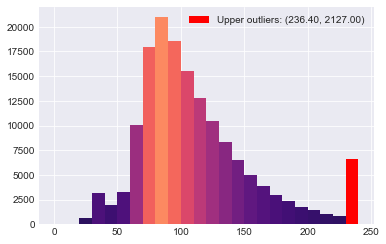

In [40]:
amsterdamumcdb.outliers_histogram(data=oxygenation['PaO2'].dropna()).show()

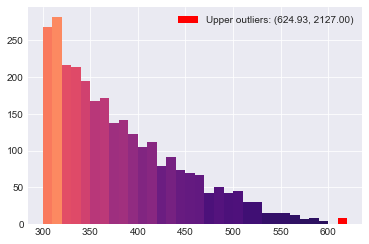

In [41]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[oxygenation['PaO2'] > 300,'PaO2']).show()

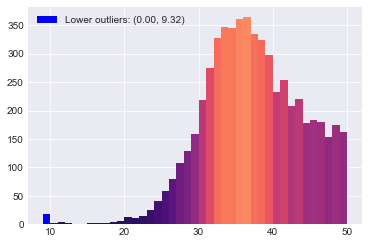

In [42]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[(oxygenation['PaO2'] < 50), 'PaO2']).show()

In [43]:
#remove lower outliers, most likely incorrectly labeled as 'arterial' instead of '(mixed/central) venous'
oxygenation.loc[oxygenation['PaO2'] < 50, 'PaO2'] = np.NaN
oxygenation = oxygenation.dropna(subset=['PaO2'])

In [44]:
#drop row without PaCO2 measurement - probably temporary measurement error
oxygenation = oxygenation.dropna(subset=['PaCO2'])

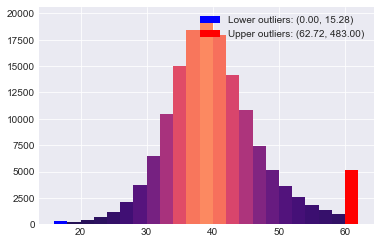

In [45]:
amsterdamumcdb.outliers_histogram(data=oxygenation['PaCO2']).show()

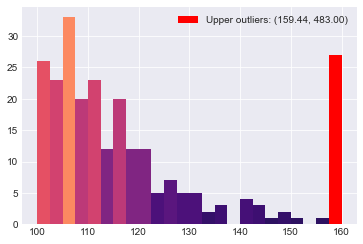

In [46]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[(oxygenation['PaCO2'] > 100), 'PaCO2']).show()

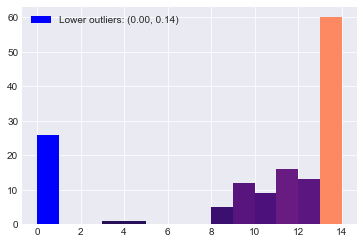

In [47]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[(oxygenation['PaCO2'] < 15), 'PaCO2']).show()

In [48]:
#remove outliers, but only when manually entered, since labs are considered accurate
oxygenation.loc[(oxygenation['PaCO2'] > 100) & (oxygenation['manual_entry'] == True), 'PaCO2'] = np.NaN
oxygenation.loc[(oxygenation['PaCO2'] < 15) & (oxygenation['manual_entry'] == True), 'PaCO2'] = np.NaN
oxygenation = oxygenation.dropna(subset=['PaCO2'])

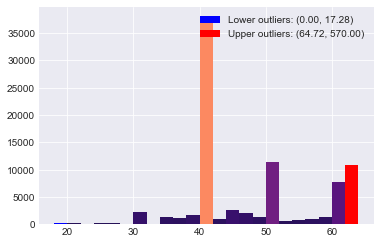

In [49]:
amsterdamumcdb.outliers_histogram(data=oxygenation['FiO2'].dropna()).show()

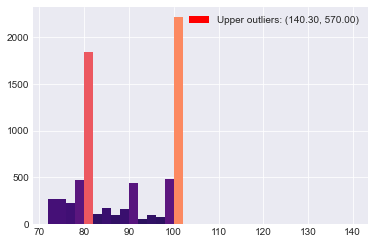

In [50]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[oxygenation['FiO2'] > 70, 'FiO2'].dropna()).show()

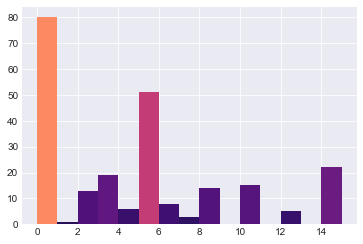

In [51]:
amsterdamumcdb.outliers_histogram(data=oxygenation.loc[oxygenation['FiO2'] < 20, 'FiO2'].dropna()).show()

In [52]:
#remove impossible FiO2 outliers (i.e. > 100% or <21%)
oxygenation.loc[(oxygenation['FiO2'] > 100), 'FiO2'] = np.NaN
oxygenation.loc[(oxygenation['FiO2'] < 20), 'FiO2'] = np.NaN

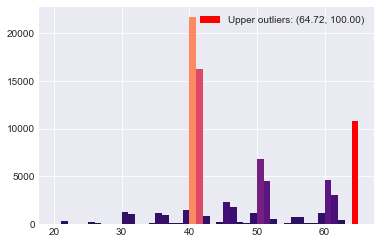

In [53]:
amsterdamumcdb.outliers_histogram(data=oxygenation['FiO2'].dropna()).show()

$$\require{mhchem}$$
The equation for calculating the A–aDO2 gradient is:

\begin{equation*}
{\displaystyle {\text{A–aDO2}}=\left(F_{i}{\ce {O2}}(P_{\text{atm}}-P_{{\ce {H2O}}})-{\frac {P_{a}{\ce {CO2}}}{0.8}}\right)-P_{a}{\ce {O2}}}
\end{equation*}

https://en.wikipedia.org/wiki/Alveolar%E2%80%93arterial_gradient

In [54]:
#Patm = 760 mmHg, PH2O = 47 mmHg
oxygenation['AaDO2'] = ((oxygenation['FiO2'] / 100) * (760 - 47) - (oxygenation['PaCO2']/ 0.8)) - oxygenation['PaO2']
oxygenation.head()

,admissionid,PaO2,PaCO2,specimen_source,manual_entry,time,FiO2,fio2_time_difference,priority,AaDO2
0,0,90.0,39.0,None,True,342,50.0,0.0,1,217.75
1,0,149.0,37.0,None,True,432,51.0,0.0,1,168.38
2,0,104.0,36.0,None,True,552,41.0,0.0,1,143.33
4,0,105.0,37.0,None,True,732,41.0,0.0,1,141.08
5,0,90.0,42.0,None,True,927,41.0,-15.0,1,149.83


In [55]:
#calculate the oxygenation score
oxygenation['a2_oxygenation_score'] = 0
oxygenation.loc[(oxygenation['FiO2'] > 50) & (oxygenation['AaDO2'] >= 500), 'a2_oxygenation_score'] = 4
oxygenation.loc[(oxygenation['FiO2'] > 50) & (oxygenation['AaDO2'] >= 350) & (oxygenation['AaDO2'] < 500), 'a2_oxygenation_score'] = 3
oxygenation.loc[(oxygenation['FiO2'] > 50) & (oxygenation['AaDO2'] >= 200) & (oxygenation['AaDO2'] < 350), 'a2_oxygenation_score'] = 2
oxygenation.loc[(oxygenation['FiO2'] > 50) & (oxygenation['AaDO2'] < 200), 'a2_oxygenation_score'] = 0
oxygenation.loc[((oxygenation['FiO2'] < 50) | (oxygenation['FiO2'].isna())) & (oxygenation['PaO2'] > 70), 'a2_oxygenation_score'] = 0
oxygenation.loc[((oxygenation['FiO2'] < 50) | (oxygenation['FiO2'].isna())) & (oxygenation['PaO2'] > 60) & (oxygenation['PaO2'] <= 70), 'a2_oxygenation_score'] = 1
oxygenation.loc[((oxygenation['FiO2'] < 50) | (oxygenation['FiO2'].isna())) & (oxygenation['PaO2'] >= 55) & (oxygenation['PaO2'] <= 60), 'a2_oxygenation_score'] = 3
oxygenation.loc[((oxygenation['FiO2'] < 50) | (oxygenation['FiO2'].isna())) & (oxygenation['PaO2'] < 55), 'a2_oxygenation_score'] = 4

#### APACHE II: Arterial pH

In [56]:
# APACHE II: Arterial pH - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('^pH|pH$', flags=re.IGNORECASE)][['itemid','item']]

,itemid,item
373,16625,MCA_Arteriële_PH
402,14467,RA_Arteriële_PH
1173,13080,A_Arteriële_PH
1181,19943,Phase angle
2759,6848,PH
2872,7126,PH in urine
2896,12310,pH (bloed)
3239,11424,pH (overig)
3241,11550,pH-gemeten (overig)
3254,18490,pH pleuravocht (pleurapunct.)


In [57]:
#get arterial pH
sql_pH = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    f.value AS specimen_source,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN freetextitems f ON
    n.admissionid = f.admissionid AND
    n.measuredat = f.measuredat AND
    f.itemid = 11646 --Afname (bloed): source of specimen (arterial)
WHERE n.itemid IN (
    6848, --PH
    12310 --pH (bloed)
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
AND (f.value ILIKE '%art.%' OR f.value IS NULL) -- source is arterial or undefined (assume arterial)
"""
pH = pd.read_sql(sql_pH, con)
pH.head()

,admissionid,itemid,item,value,specimen_source,registeredby,manual_entry,time
0,656,6848,PH,7.45,None,ICV_IC-Verpleegkundig,True,240
1,525,6848,PH,7.36,None,ICV_IC-Verpleegkundig,True,562
2,559,6848,PH,7.34,None,ICV_Medisch,True,895
3,564,6848,PH,7.40,None,ICV_IC-Verpleegkundig,True,723
4,573,6848,PH,7.38,None,ICV_Medisch,True,1105


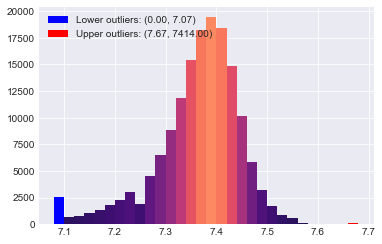

In [58]:
amsterdamumcdb.outliers_histogram(data=pH['value'].dropna()).show()

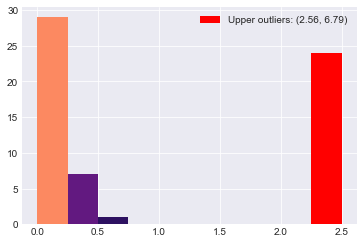

In [59]:
amsterdamumcdb.outliers_histogram(data=pH.loc[(pH['value'] < 6.8) & (pH['manual_entry'] == True), 'value'].dropna()).show()

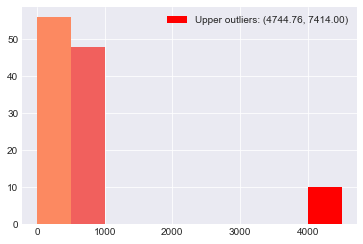

In [60]:
amsterdamumcdb.outliers_histogram(data=pH.loc[(pH['value'] > 7.68), 'value'].dropna()).show()

In [61]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
pH.loc[(pH['value'] < 6.8) & (pH['manual_entry'] == True), 'value'] = np.NaN
pH.loc[(pH['value'] > 7.6) & (pH['manual_entry'] == True), 'value'] = np.NaN
pH = pH.dropna(subset=['value'])

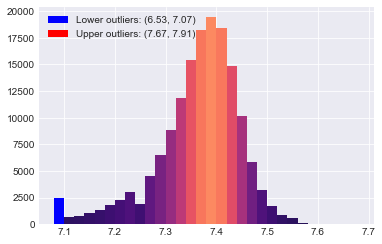

In [62]:
amsterdamumcdb.outliers_histogram(data=pH['value'].dropna()).show()

In [63]:
#calculate the pH score
pH['a2_pH_score'] = 0
pH.loc[(pH['value'] >= 7.7), 'a2_pH_score'] = 4
pH.loc[(pH['value'] >= 7.6) & (pH['value'] < 7.7), 'a2_pH_score'] = 3
pH.loc[(pH['value'] >= 7.5) & (pH['value'] < 7.6), 'a2_pH_score'] = 1
pH.loc[(pH['value'] >= 7.33) & (pH['value'] < 7.5), 'a2_pH_score'] = 0
pH.loc[(pH['value'] >= 7.25) & (pH['value'] < 7.33), 'a2_pH_score'] = 2
pH.loc[(pH['value'] >= 7.15) & (pH['value'] < 7.25), 'a2_pH_score'] = 3
pH.loc[(pH['value'] < 7.15), 'a2_pH_score'] = 4

#### APACHE II: Serum sodium (mmol/l)

In [64]:
# APACHE II: Serum sodium (mmol/l) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))na(?:trium)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2772,9555,Natrium Astrup,sodium - direct ion specific electrode measurement,97.0,mmol/l,19785,19785,19785.0
2803,6840,Natrium,serum sodium,97.0,mmol/l,8602,8602,8602.0
2878,7848,Natrium in urine,NaN,97.0,mmol/l,110,110,110.0
2905,9924,Natrium (bloed),sodium,97.0,mmol/l,226219,226219,226219.0
2952,10284,Na (onv.ISE) (bloed),sodium - direct ion specific electrode measurement,97.0,mmol/l,527724,527724,527724.0
3019,9926,NATRIUM (overig),NaN,97.0,mmol/l,58,58,58.0
3047,12233,Natrium (overig),NaN,157.0,µmol/24uur,1,1,1.0
3074,18476,Natrium dialysaat (dialysaat),NaN,97.0,mmol/l,1,1,1.0
3091,10336,NATRIUM (faeces),NaN,97.0,mmol/l,23,23,23.0
3099,19351,Natrium (faeces verzameld),NaN,316.0,mmol/24uur,1,1,1.0


In [65]:
#get serum Na
sql_sodium = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    6840, --Natrium
    9555, --Natrium Astrup
    9924, --Natrium (bloed)
    10284 --Na (onv.ISE) (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    
"""
sodium = pd.read_sql(sql_sodium, con)
sodium.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6840,Natrium,139.0,ICV_Medisch,True,15
1,12,6840,Natrium,141.0,ICV_IC-Verpleegkundig,True,375
2,43,6840,Natrium,139.0,ICV_Medisch,True,50
3,43,6840,Natrium,143.0,ICV_IC-Verpleegkundig,True,830
4,102,6840,Natrium,138.0,ICV_Medisch,True,60


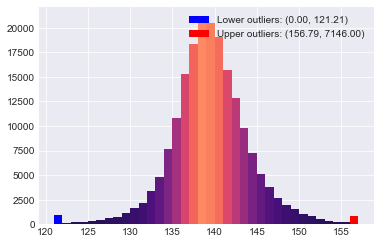

In [66]:
amsterdamumcdb.outliers_histogram(data=sodium['value']).show()

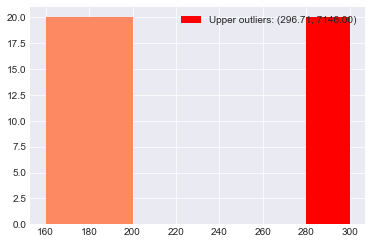

In [67]:
amsterdamumcdb.outliers_histogram(data=sodium.loc[(sodium['value'] > 165) & (sodium['manual_entry'] == True), 'value']).show()

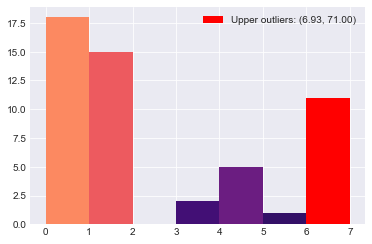

In [68]:
amsterdamumcdb.outliers_histogram(data=sodium.loc[(sodium['value'] < 95) & (sodium['manual_entry'] == True), 'value']).show()

In [69]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
sodium.loc[(sodium['value'] > 165) & (sodium['manual_entry'] == True), 'value'] = np.NaN
sodium.loc[(sodium['value'] < 95) & (sodium['manual_entry'] == True), 'value'] = np.NaN
sodium = sodium.dropna()

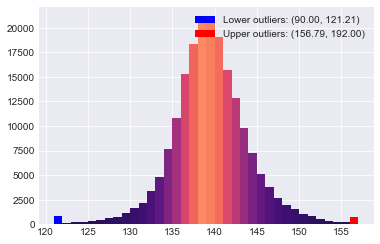

In [70]:
amsterdamumcdb.outliers_histogram(data=sodium['value']).show()

In [71]:
#calculate the sodium score
sodium['a2_sodium_score'] = 0
sodium.loc[(sodium['value'] >= 180), 'a2_sodium_score'] = 4
sodium.loc[(sodium['value'] >= 160) & (sodium['value'] < 180), 'a2_sodium_score'] = 3
sodium.loc[(sodium['value'] >= 155) & (sodium['value'] < 160), 'a2_sodium_score'] = 2
sodium.loc[(sodium['value'] >= 150) & (sodium['value'] < 155), 'a2_sodium_score'] = 1
sodium.loc[(sodium['value'] >= 130) & (sodium['value'] < 150), 'a2_sodium_score'] = 0
sodium.loc[(sodium['value'] >= 120) & (sodium['value'] < 130), 'a2_sodium_score'] = 2
sodium.loc[(sodium['value'] > 111) & (sodium['value'] < 120), 'a2_sodium_score'] = 3
sodium.loc[(sodium['value'] <= 110), 'a2_sodium_score'] = 4

#### APACHE II: Serum potassium (mmol/l)

In [72]:
# APACHE II: Serum potassium (mmol/l) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))K(?:alium)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2773,9556,Kalium Astrup,potassium - direct ion specific electrode measurement,97.0,mmol/l,20082,20082,20082.0
2798,6835,Kalium,serum potassium,97.0,mmol/l,8612,8612,8612.0
2869,7101,Kalium in urine,NaN,97.0,mmol/l,60,60,60.0
2906,9927,Kalium (bloed),potassium,97.0,mmol/l,220787,220787,220787.0
2953,10285,K (onv.ISE) (bloed),potassium - direct ion specific electrode measurement,97.0,mmol/l,542007,542007,542007.0
3020,9929,Kalium (overig),NaN,97.0,mmol/l,23,23,23.0
3068,18417,Kalium dialysaat (dialysaat),NaN,97.0,mmol/l,1,1,1.0
3092,10337,Kalium (faeces),NaN,97.0,mmol/l,23,23,23.0
3100,19352,Kalium (faeces verzameld),NaN,316.0,mmol/24uur,1,1,1.0
3114,10271,Kalium (urine),NaN,97.0,mmol/l,1993,1993,1993.0


In [73]:
#get serum K
sql_potassium = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    6835, --Kalium mmol/l
    9556, --Kalium Astrup mmol/l
    9927, --Kalium (bloed) mmol/l
    10285 --K (onv.ISE) (bloed) mmol/l
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    
"""
potassium = pd.read_sql(sql_potassium, con)
potassium.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6835,Kalium,4.1,ICV_Medisch,True,15
1,12,6835,Kalium,3.9,ICV_IC-Verpleegkundig,True,375
2,43,6835,Kalium,3.9,ICV_Medisch,True,50
3,43,6835,Kalium,3.8,ICV_IC-Verpleegkundig,True,830
4,102,6835,Kalium,3.6,ICV_Medisch,True,60


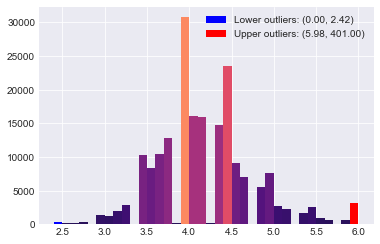

In [74]:
amsterdamumcdb.outliers_histogram(data=potassium['value']).show()

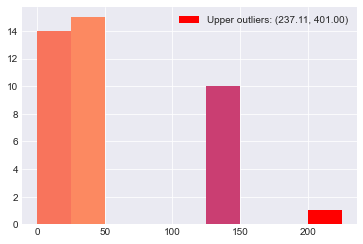

In [75]:
amsterdamumcdb.outliers_histogram(data=potassium.loc[(potassium['value'] > 8) & (potassium['manual_entry'] == True), 'value']).show()

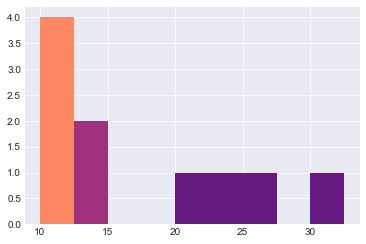

In [76]:
#most likely sample collected from/near potossium i.v. line
amsterdamumcdb.outliers_histogram(data=potassium.loc[(potassium['value'] > 10) & (potassium['manual_entry'] == False), 'value']).show()

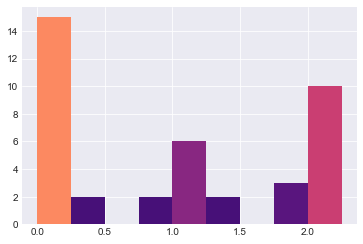

In [77]:
amsterdamumcdb.outliers_histogram(data=potassium.loc[(potassium['value'] <= 2.2) & (potassium['manual_entry'] == True), 'value']).show()

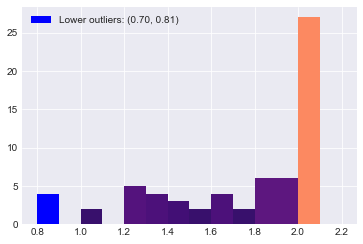

In [78]:
#most likely sample collected from/near i.v. line 
amsterdamumcdb.outliers_histogram(data=potassium.loc[(potassium['value'] <= 2.2) & (potassium['manual_entry'] == False), 'value']).show()

In [79]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
potassium.loc[potassium['admissionid'].isin(
    potassium.loc[(potassium['value'] <= 2.2) & (potassium['manual_entry'] == False), 'admissionid'])
             ].sort_values(by='admissionid').head()

#just remove all outliers <= 2.2. for APACHE II

,admissionid,itemid,item,value,registeredby,manual_entry,time
8562,165,9927,Kalium (bloed),3.8,Systeem,False,69
8563,165,9927,Kalium (bloed),3.4,Systeem,False,231
8564,165,9927,Kalium (bloed),3.3,Systeem,False,424
8565,165,9927,Kalium (bloed),2.4,Systeem,False,668
8566,165,9927,Kalium (bloed),2.3,Systeem,False,985


In [80]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
potassium.loc[(potassium['value'] > 8) & (potassium['manual_entry'] == True), 'value'] = np.NaN
potassium.loc[(potassium['value'] < 2) & (potassium['manual_entry'] == True), 'value'] = np.NaN
potassium.loc[(potassium['value'] <= 2.2) & (potassium['manual_entry'] == False), 'value'] = np.NaN
potassium.loc[(potassium['value'] > 10) & (potassium['manual_entry'] == False), 'value'] = np.NaN
potassium = potassium.dropna()

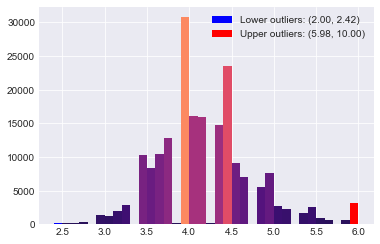

In [81]:
amsterdamumcdb.outliers_histogram(data=potassium['value']).show()

In [82]:
#calculate the potassium score
potassium['a2_potassium_score'] = 0
potassium.loc[(potassium['value'] >= 7), 'a2_potassium_score'] = 4
potassium.loc[(potassium['value'] >= 6) & (potassium['value'] < 7), 'a2_potassium_score'] = 3
potassium.loc[(potassium['value'] >= 5.5) & (potassium['value'] < 6), 'a2_potassium_score'] = 1
potassium.loc[(potassium['value'] >= 3.5) & (potassium['value'] < 5.5), 'a2_potassium_score'] = 0
potassium.loc[(potassium['value'] >= 3) & (potassium['value'] < 3.5), 'a2_potassium_score'] = 1
potassium.loc[(potassium['value'] >= 2.5) & (potassium['value'] < 3), 'a2_potassium_score'] = 2
potassium.loc[(potassium['value'] < 2.5), 'a2_potassium_score'] = 4

#### <a id='creatinine'></a> APACHE II: Serum creatinine (mg/100 ml)

In [83]:
# APACHE II: Serum creatinine (mg/100 ml) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))(?:k|c)?reat(?:inin)?(?:e)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2799,6836,Kreatinine,serum creatinine,56.0,µmol,6481,6481,6481.0
2870,7108,Kreatinine klaring,NaN,24.0,ml/min,2,2,2.0
2871,7109,Kreatinine in urine,NaN,97.0,mmol/l,47,47,47.0
2912,9941,Kreatinine (bloed),serum creatinine,99.0,µmol/l,196186,196186,196186.0
2996,14216,KREAT enzym. (bloed),serum creatinine,99.0,µmol/l,33,33,33.0
3025,9942,Kreatinine (Jaffé) (overig),NaN,99.0,µmol/l,43,43,43.0
3044,12191,Kreatinine (Jaffé) (overig),NaN,97.0,mmol/l,16,16,16.0
3059,14441,Kreatinine (overig),NaN,99.0,µmol/l,197,197,197.0
3069,18430,Kreatinine dialysaat (dialysaat),NaN,99.0,µmol/l,3,3,3.0
3118,10279,Kreatinine (urine),NaN,97.0,mmol/l,3340,3340,3340.0


In [84]:
#get serum creatinine
sql_creatinine = """
WITH baseline AS (
    SELECT n.admissionid,
    MIN(n.value) AS baseline_creatinine
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --search 1 year befor admission
    (n.measuredat - a.admittedat)/(60*60*1000) > -(365*24) AND (n.measuredat - a.admittedat) < (24*60*60*1000)
    GROUP BY n.admissionid
),
max_creat AS (
    SELECT n.admissionid,
    MAX(n.value) AS max_creatinine_7days
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --within 7 days of admission
    (n.measuredat - a.admittedat) > 0 AND (n.measuredat - a.admittedat) < (7*24*60*60*1000)
    GROUP BY n.admissionid
)
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time,
    b.baseline_creatinine,
    m.max_creatinine_7days,
    CASE
        -- AKI definition: 3 fold increase:
        WHEN baseline_creatinine > 0 AND m.max_creatinine_7days/baseline_creatinine > 3 THEN TRUE
        -- AKI definition: increase to >= 354 umol/l AND at least 44 umol/l increase:
        WHEN max_creatinine_7days >= 354 AND max_creatinine_7days - baseline_creatinine >= 44 THEN TRUE 
        ELSE FALSE
    END AS acute_renal_failure
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN baseline b ON -- get the baseline kreat (before admission)
    n.admissionid = b.admissionid
LEFT JOIN max_creat m ON --get the highest within a week of admission
    n.admissionid = m.admissionid
WHERE n.itemid IN (
    6836, --Kreatinine µmol/l (erroneously documented as µmol)
    9941, --Kreatinine (bloed) µmol/l
    14216 --KREAT enzym. (bloed) µmol/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
"""
creatinine = pd.read_sql(sql_creatinine, con)
creatinine.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
0,12,6836,Kreatinine,77.0,ICV_Medisch,True,15,77.0,77.0,False
1,43,6836,Kreatinine,70.0,ICV_Medisch,True,50,66.0,70.0,False
2,43,6836,Kreatinine,66.0,ICV_IC-Verpleegkundig,True,830,66.0,70.0,False
3,102,6836,Kreatinine,84.0,ICV_Medisch,True,60,84.0,84.0,False
4,130,6836,Kreatinine,106.0,ICV_Medisch,True,121,106.0,106.0,False


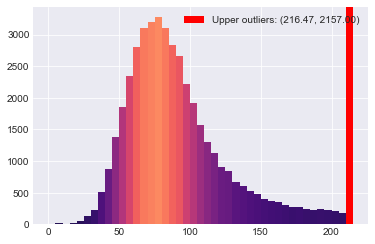

In [85]:
amsterdamumcdb.outliers_histogram(data=creatinine['value']).show()

In [86]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value']> 1000) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
421,5819,6836,Kreatinine,1013.0,ICV_IC-Verpleegkundig,True,12,385.0,1013.0,True
422,5819,6836,Kreatinine,680.0,ICV_IC-Verpleegkundig,True,672,385.0,1013.0,True
423,5819,6836,Kreatinine,385.0,ICV_Medisch Staflid,True,1392,385.0,1013.0,True
16717,7637,9941,Kreatinine (bloed),2157.0,ICV_Medisch Staflid,True,1,1078.0,2157.0,True
16718,7637,9941,Kreatinine (bloed),1720.0,Systeem,False,156,1078.0,2157.0,True
16719,7637,9941,Kreatinine (bloed),1144.0,Systeem,False,718,1078.0,2157.0,True
16720,7637,9941,Kreatinine (bloed),1078.0,Systeem,False,1111,1078.0,2157.0,True
27746,13151,9941,Kreatinine (bloed),1291.0,Systeem,False,70,1291.0,1355.0,True
27747,13151,9941,Kreatinine (bloed),1355.0,ICV_IC-Verpleegkundig,True,409,1291.0,1355.0,True


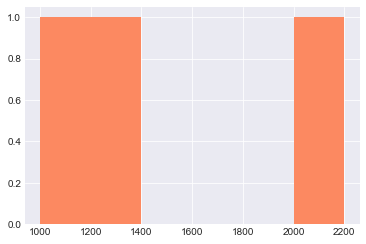

In [87]:
amsterdamumcdb.outliers_histogram(data=creatinine.loc[(creatinine['value'] > 1000) & (creatinine['manual_entry'] == True), 'value']).show()

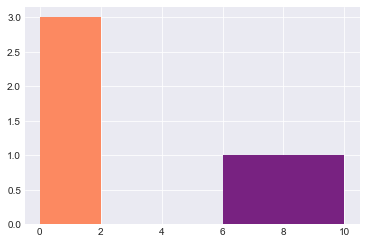

In [88]:
amsterdamumcdb.outliers_histogram(data=creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value']).show()

In [89]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
523,7132,6836,Kreatinine,113.0,ICV_IC-Verpleegkundig,True,275,0.0,113.0,False
524,7132,6836,Kreatinine,0.0,ICV_IC-Verpleegkundig,True,514,0.0,113.0,False
525,7132,6836,Kreatinine,107.0,ICV_Medisch,True,875,0.0,113.0,False
1008,13794,6836,Kreatinine,113.0,ICV_IC-Verpleegkundig,True,109,11.0,118.0,True
1009,13794,6836,Kreatinine,112.0,ICV_IC-Verpleegkundig,True,649,11.0,118.0,True
1010,13794,6836,Kreatinine,11.0,ICV_IC-Verpleegkundig,True,949,11.0,118.0,True
32604,15626,9941,Kreatinine (bloed),219.0,Systeem,False,144,0.0,330.0,False
32605,15626,9941,Kreatinine (bloed),330.0,Systeem,False,1091,0.0,330.0,False
1156,15626,6836,Kreatinine,219.0,ICV_IC-Verpleegkundig,True,131,0.0,330.0,False
1157,15626,6836,Kreatinine,0.0,ICV_IC-Verpleegkundig,True,191,0.0,330.0,False


In [90]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value'] = np.NaN
creatinine = creatinine.dropna(subset=['value'])

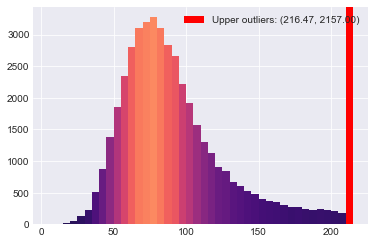

In [91]:
amsterdamumcdb.outliers_histogram(data=creatinine['value']).show()

In [92]:
#conversion umol/l to mg/dl
#creatinine molar mass: 113.120 g·mol−1
creatinine['value_non_si'] = (creatinine['value']/10e6)*(10e3/10)*113.120
creatinine.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure,value_non_si
0,12,6836,Kreatinine,77.0,ICV_Medisch,True,15,77.0,77.0,False,0.871024
1,43,6836,Kreatinine,70.0,ICV_Medisch,True,50,66.0,70.0,False,0.791840
2,43,6836,Kreatinine,66.0,ICV_IC-Verpleegkundig,True,830,66.0,70.0,False,0.746592
3,102,6836,Kreatinine,84.0,ICV_Medisch,True,60,84.0,84.0,False,0.950208
4,130,6836,Kreatinine,106.0,ICV_Medisch,True,121,106.0,106.0,False,1.199072


In [93]:
#calculate the creatinine score

#if acute renal failure (AKI definition), double the points
creatinine['score_multiplier'] = 1
creatinine.loc[(creatinine['acute_renal_failure'] == True), 'score_multiplier'] = 2

creatinine['a2_creatinine_score'] = 0
creatinine.loc[(creatinine['value_non_si'] >= 3.5), 'a2_creatinine_score'] = 4 * creatinine['score_multiplier']
creatinine.loc[(creatinine['value_non_si'] >= 2) & (creatinine['value_non_si'] < 3.5), 'a2_creatinine_score'] = 3 * creatinine['score_multiplier']
creatinine.loc[(creatinine['value_non_si'] >= 1.5) & (creatinine['value_non_si'] < 2), 'a2_creatinine_score'] = 2 * creatinine['score_multiplier']
creatinine.loc[(creatinine['value_non_si'] >= 0.6) & (creatinine['value_non_si'] < 1.5), 'a2_creatinine_score'] = 0
creatinine.loc[(creatinine['value_non_si'] < 0.6), 'a2_creatinine_score'] = 2 * creatinine['score_multiplier']

#### APACHE II: Hematocrit (%)

In [94]:
# APACHE II: Hematocrit (%) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))(?:k|c)?H(?:(?:a)?ematocri(?:e)?)?t(?:$|(?=\W))',
                                                               flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2044,20661,ECMO - Ht,NaN,191.0,Geen,457,457,457.0
2826,6777,Hematocriet,hematocrit,8.0,l,7511,7511,7511.0
3469,11423,Ht (bloed),hematocrit,191.0,Geen,200516,200516,200516.0
3473,11545,Ht(v.Bgs) (bloed),hematocrit,191.0,Geen,494384,494384,494384.0
3624,11559,Ht (overig),NaN,191.0,Geen,11,11,11.0
3642,18861,Ht pleuravocht (pleurapunct.),NaN,191.0,Geen,7,7,7.0


In [95]:
#get hematocrit
sql_ht = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    6777, --Hematocriet
    11423, --Ht (bloed)
    11545 --Ht(v.Bgs) (bloed)
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    
 
"""
ht = pd.read_sql(sql_ht, con)
ht.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6777,Hematocriet,0.27,ICV_Medisch,True,15
1,12,6777,Hematocriet,0.27,ICV_Medisch,True,75
2,12,6777,Hematocriet,0.26,ICV_IC-Verpleegkundig,True,375
3,43,6777,Hematocriet,0.23,ICV_Medisch,True,20
4,43,6777,Hematocriet,0.29,ICV_IC-Verpleegkundig,True,830


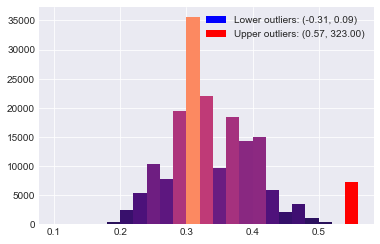

In [96]:
amsterdamumcdb.outliers_histogram(data=ht['value']).show()

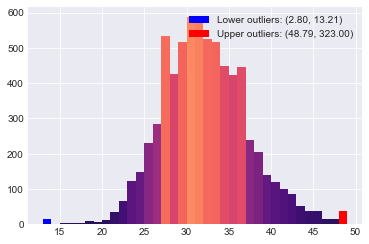

In [97]:
amsterdamumcdb.outliers_histogram(data=ht.loc[(ht['value'] > 1) & (ht['manual_entry'] == True), 'value']).show()

In [98]:
#manually entered values in (0-100%) % instead of fraction (0-1)
ht.loc[(ht['value'] > 1) & (ht['manual_entry'] == True), 'value'] = ht.loc[
    (ht['value'] > 1) & (ht['manual_entry'] == True), 'value']/100

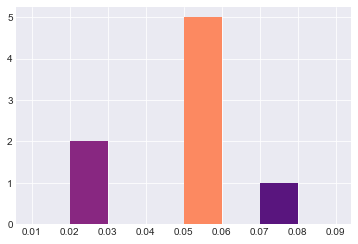

In [99]:
amsterdamumcdb.outliers_histogram(data=ht.loc[(ht['value'] < .1) & (ht['manual_entry'] == False), 'value']).show()

In [100]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
ht.loc[ht['admissionid'].isin(
    ht.loc[(ht['value'] < .1) & (ht['manual_entry'] == False), 'admissionid'])
             ].sort_values(by='admissionid').head(5)

,admissionid,itemid,item,value,registeredby,manual_entry,time
4846,920,11423,Ht (bloed),0.25,Systeem,False,24
65037,920,11545,Ht(v.Bgs) (bloed),0.30,Systeem,False,496
4849,920,11423,Ht (bloed),0.29,Systeem,False,505
65038,920,11545,Ht(v.Bgs) (bloed),0.28,Systeem,False,579
4847,920,11423,Ht (bloed),0.06,Systeem,False,192


In [101]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
ht.loc[ht['admissionid'].isin(
    ht.loc[(ht['value'] > .67) & (ht['manual_entry'] == False), 'admissionid'])
             ].sort_values(by=['admissionid','time']).head(5)

,admissionid,itemid,item,value,registeredby,manual_entry,time
70294,1963,11545,Ht(v.Bgs) (bloed),0.26,Systeem,False,151
70295,1963,11545,Ht(v.Bgs) (bloed),0.25,Systeem,False,181
70296,1963,11545,Ht(v.Bgs) (bloed),0.25,Systeem,False,184
70297,1963,11545,Ht(v.Bgs) (bloed),0.80,Systeem,False,190
70298,1963,11545,Ht(v.Bgs) (bloed),0.29,Systeem,False,217


In [102]:
#remove extreme outliers, most likely sample collection error (near transfusion site)
ht.loc[(ht['value'] < .1), 'value'] = np.NaN
ht.loc[(ht['value'] > .67), 'value'] = np.NaN
ht = ht.dropna()

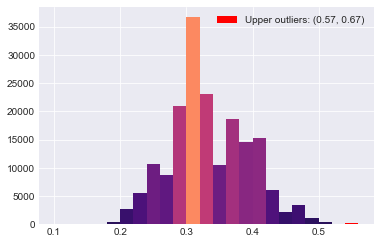

In [103]:
amsterdamumcdb.outliers_histogram(data=ht['value']).show()

In [104]:
#calculate the hematocrit score
ht['a2_ht_score'] = 0
ht.loc[(ht['value'] >= 0.60), 'a2_ht_score'] = 4
ht.loc[(ht['value'] >= 0.50) & (ht['value'] < 0.60), 'a2_ht_score'] = 2
ht.loc[(ht['value'] >= 0.46) & (ht['value'] < 0.50), 'a2_ht_score'] = 1
ht.loc[(ht['value'] >= 0.30) & (ht['value'] < 0.46), 'a2_ht_score'] = 0
ht.loc[(ht['value'] >= 0.20) & (ht['value'] < 0.30), 'a2_ht_score'] = 2
ht.loc[(ht['value'] < 0.20), 'a2_ht_score'] = 4

#### APACHE II: White blood count (total/mm3) (in 1000s)

In [105]:
# APACHE II: White blood count (total/mm3) (in 1000s) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))leu(?:k|c)o(?:cyt\w|\'s)\w?(?:$|(?=\W))',
                                                               flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
2828,6779,Leucocyten,white blood cell count,101.0,10^9/l,6474,6474,6474.0
3269,11663,Leuco's/uL (liquor),NaN,197.0,/µl,2416,2416,2416.0
3421,9965,Leuco's (bloed),white blood cell count,101.0,10^9/l,191174,191174,191174.0
3618,9966,Leuco's (overig),NaN,101.0,10^9/l,424,424,424.0
3634,18442,Leuco's ascitesvocht (ascitesvocht),NaN,101.0,10^9/l,72,72,72.0
3635,18443,Leuco's dialysaat (dialysaat),NaN,101.0,10^9/l,8,8,8.0
3636,18444,Leuco's drainvocht (drain),NaN,101.0,10^9/l,7,7,7.0
3637,18445,Leuco's peritoneaalvocht (perito.vocht capd),NaN,101.0,10^9/l,16,16,16.0
3638,18446,Leuco's pleuravocht (pleurapunct.),NaN,101.0,10^9/l,62,62,62.0


In [106]:
#get white blood count
sql_wbc = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    6779, --Leucocyten 10^9/l
    9965 --Leuco's (bloed) 10^9/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    

"""
wbc = pd.read_sql(sql_wbc, con)
wbc.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6779,Leucocyten,13.7,ICV_IC-Verpleegkundig,True,375
1,43,6779,Leucocyten,9.8,ICV_Medisch,True,20
2,43,6779,Leucocyten,10.6,ICV_IC-Verpleegkundig,True,830
3,102,6779,Leucocyten,8.8,ICV_Medisch,True,60
4,130,6779,Leucocyten,11.5,ICV_Medisch,True,1141


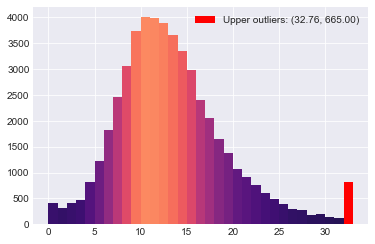

In [107]:
amsterdamumcdb.outliers_histogram(data=wbc['value']).show()

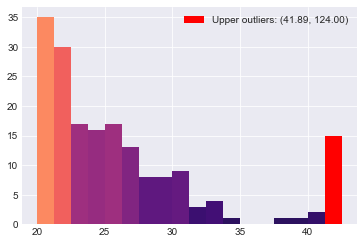

In [108]:
amsterdamumcdb.outliers_histogram(data=wbc.loc[(wbc['value'] > 20) & (wbc['manual_entry'] == True), 'value']).show()

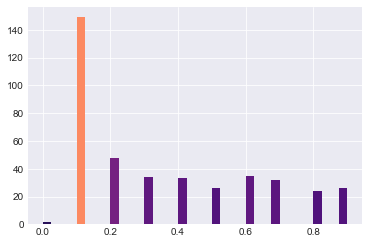

In [109]:
amsterdamumcdb.outliers_histogram(data=wbc.loc[(wbc['value'] < 1), 'value']).show()

In [110]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
wbc.loc[wbc['admissionid'].isin(
    wbc.loc[(wbc['value'] > 60) & (wbc['manual_entry'] == False), 'admissionid'])
             ].sort_values(by='admissionid').head(5)

,admissionid,itemid,item,value,registeredby,manual_entry,time
2315,268,9965,Leuco's (bloed),177.000000,Systeem,False,49
2316,268,9965,Leuco's (bloed),125.000000,Systeem,False,598
2317,268,9965,Leuco's (bloed),80.800003,Systeem,False,1050
5461,1778,9965,Leuco's (bloed),72.900002,Systeem,False,150
5462,1778,9965,Leuco's (bloed),76.300003,Systeem,False,827


In [111]:
#separator error: e.g. 117 > 11.7
wbc.loc[(wbc['value'] > 70) & (wbc['manual_entry'] == True), 'value'] = wbc.loc[
    (wbc['value'] > 70) & (wbc['manual_entry'] == True), 'value']/10

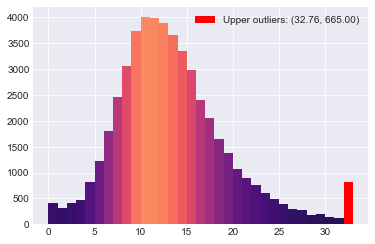

In [112]:
amsterdamumcdb.outliers_histogram(data=wbc['value']).show()

In [113]:
#calculate the WBC score
wbc['a2_wbc_score'] = 0
wbc.loc[(wbc['value'] >= 40), 'a2_wbc_score'] = 4
wbc.loc[(wbc['value'] >= 20) & (wbc['value'] < 40), 'a2_wbc_score'] = 2
wbc.loc[(wbc['value'] >= 15) & (wbc['value'] < 20), 'a2_wbc_score'] = 1
wbc.loc[(wbc['value'] >= 3) & (wbc['value'] < 15), 'a2_wbc_score'] = 0
wbc.loc[(wbc['value'] >= 1) & (wbc['value'] < 3), 'a2_wbc_score'] = 2
wbc.loc[(wbc['value'] < 1), 'a2_wbc_score'] = 4

#### <a id='gcs'></a>APACHE II: Glasgow Coma Score (GCS) - Score = 15 minus actual GCS

In [114]:
# APACHE II: Glasgow Coma Score (GCS) - Score = 15 minus actual GCS - possible parameters
listitems_itemids[listitems_itemids['item'].str.contains('(?:^|\_|(?<=\W))\w*(?:Eye|ogen|Motor|Verb|GCS|EMV)\w*(?:$|\_|(?=\W))',
                                                               flags=re.IGNORECASE)]

,itemid,item,item_en,valueid,value,count,count_validated
377,16628,MCA_Eye,Glasgow Coma Score eye opening subscore,5.0,Niet,55,55.0
378,16628,MCA_Eye,Glasgow Coma Score eye opening subscore,6.0,Op pijn,11,11.0
379,16628,MCA_Eye,Glasgow Coma Score eye opening subscore,7.0,Op aanspreken,177,177.0
380,16628,MCA_Eye,Glasgow Coma Score eye opening subscore,8.0,Spontaan,1680,1680.0
384,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,7.0,Geen reactie,33,33.0
385,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,8.0,Strekken op pijn,3,3.0
386,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,9.0,Abnormaal buigen bij pijn,3,3.0
387,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,10.0,Terugtrekken bij pijn,33,33.0
388,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,11.0,Localiseren pijn,177,177.0
389,16634,MCA_Motoriek,Glasgow Coma Score motor response subscore,12.0,Voert opdrachten uit,1673,1673.0


In [115]:
#get Glasgow Coma Scale-score
sql_gcs = """
WITH gcs_components AS (
    SELECT 
        eyes.admissionid,
        --eyes.itemid,
        --eyes.item,
        --eyes.value,
        --eyes.valueid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
            WHEN 13077 THEN eyes.valueid        --A_Eye
            WHEN 14470 THEN eyes.valueid - 4    --RA_Eye   
            WHEN 16628 THEN eyes.valueid - 4    --MCA_Eye
            WHEN 19635 THEN eyes.valueid - 4    --E_EMV_NICE_24uur
            WHEN 19638 THEN eyes.valueid - 8    --E_EMV_NICE_Opname
        END AS eyes_score,
        --motor.value,
        --motor.valueid,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
            WHEN 13072 THEN motor.valueid       --A_Motoriek
            WHEN 14476 THEN motor.valueid - 6   --RA_Motoriek
            WHEN 16634 THEN motor.valueid - 6   --MCA_Motoriek
            WHEN 19636 THEN motor.valueid - 6   --M_EMV_NICE_24uur
            WHEN 19639 THEN motor.valueid - 12  --M_EMV_NICE_Opname
        END AS motor_score,
        --verbal.value,
        --verbal.valueid,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
            WHEN 13066 THEN verbal.valueid      --A_Verbal
            WHEN 14482 THEN verbal.valueid - 5  --RA_Verbal
            WHEN 16640 THEN verbal.valueid - 5  --MCA_Verbal
            WHEN 19637 THEN verbal.valueid - 9 --V_EMV_NICE_24uur
            WHEN 19640 THEN verbal.valueid - 15 --V_EMV_NICE_Opname
        END AS verbal_score,
        eyes.registeredby,
        (eyes.measuredat - a.admittedat)/(1000*60) AS time       
    FROM listitems eyes
    LEFT JOIN admissions a ON
        eyes.admissionid = a.admissionid
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734, --Beste motore reactie van de armen
            13072, --A_Motoriek
            14476, --RA_Motoriek
            16634, --MCA_Motoriek
            19636, --M_EMV_NICE_24uur
            19639 --M_EMV_NICE_Opname   
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735, --Beste verbale reactie
            13066, --A_Verbal
            14482, --RA_Verbal
            16640, --MCA_Verbal
            19637, --V_EMV_NICE_24uur
            19640 --V_EMV_NICE_Opname
        )
    WHERE eyes.itemid IN (
        6732, --Actief openen van de ogen
        13077, --A_Eye
        14470, --RA_Eye    
        16628, --MCA_Eye
        19635, --E_EMV_NICE_24uur
        19638 --E_EMV_NICE_Opname
        )
    -- measurements within 24 hours of ICU stay:
    AND (eyes.measuredat - a.admittedat) <= 1000*60*60*24 AND (eyes.measuredat - a.admittedat) >= 0 
), gcs AS (
    SELECT *, 
        eyes_score + motor_score + (
            CASE 
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score 
            END
        ) AS gcs_score
    FROM gcs_components
), gcs_prioritized AS (
    SELECT *,
        ROW_NUMBER() OVER(
            PARTITION BY admissionid
            ORDER BY --orders by discipline
                CASE registeredby
                    WHEN 'ICV_Medisch Staflid' THEN 1
                    WHEN 'ICV_Medisch' THEN 2
                    WHEN 'ANES_Anesthesiologie'THEN 3
                    WHEN 'ICV_Physician assistant' THEN 4
                    WHEN 'ICH_Neurochirurgie'THEN 5
                    WHEN 'ICV_IC-Verpleegkundig' THEN 6
                    WHEN 'ICV_MC-Verpleegkundig' THEN 7
                    ELSE 8
                END, gcs_score
        ) AS priority 
    FROM gcs
    ORDER BY admissionid, gcs_score ASC
)
SELECT * 
FROM gcs_prioritized
WHERE priority = 1
"""
gcs = pd.read_sql(sql_gcs, con)
#len(gcs.groupby('admissionid').size())
gcs.head()

,admissionid,eyes_score,motor_score,verbal_score,registeredby,time,gcs_score,priority
0,0,4,6.0,5.0,ICV_Medisch,734,15.0,1
1,1,4,6.0,5.0,ICV_Medisch,1372,15.0,1
2,2,4,6.0,5.0,ICV_Medisch,1256,15.0,1
3,4,1,1.0,1.0,ICV_Medisch,103,3.0,1
4,5,4,6.0,5.0,ICV_Medisch Staflid,22,15.0,1


In [116]:
#calculate the GCS score
gcs['a2_gcs_score'] = 15 - gcs['gcs_score']
gcs.head()

,admissionid,eyes_score,motor_score,verbal_score,registeredby,time,gcs_score,priority,a2_gcs_score
0,0,4,6.0,5.0,ICV_Medisch,734,15.0,1,0.0
1,1,4,6.0,5.0,ICV_Medisch,1372,15.0,1,0.0
2,2,4,6.0,5.0,ICV_Medisch,1256,15.0,1,0.0
3,4,1,1.0,1.0,ICV_Medisch,103,3.0,1,12.0
4,5,4,6.0,5.0,ICV_Medisch Staflid,22,15.0,1,0.0


## APACHE II: B: Age Points

In [117]:
#calculate the age score
admissions['a2_age_score'] = 0

#since whe are using generalized ages in the database, it doesn't perfectly with the APACHE groups, so use an average
#of the definitions in APACHE II
admissions.loc[(admissions['agegroup'] == '80+'), 'a2_age_score'] = 6
admissions.loc[(admissions['agegroup'] == '70-79'), 'a2_age_score'] = (5+6)/2
admissions.loc[(admissions['agegroup'] == '60-69'), 'a2_age_score'] = (3+5)/2
admissions.loc[(admissions['agegroup'] == '50-59'), 'a2_age_score'] = (2+3)/2
admissions.loc[(admissions['agegroup'] == '40-49'), 'a2_age_score'] = (0+2)/2
admissions.loc[(admissions['agegroup'] == '18-39'), 'a2_age_score'] = 0

### APACHE II: Final score calculation

Merge all (A) physiology scores and (B) Age scores into a single dataframe

In [118]:
#merge the scores
apache_ii = admissions['admissionid']

#max temperature score 
scores = temperature[temperature['validated'] == True].groupby('admissionid')['a2_temperature_score'].max().to_frame(
    'a2_temperature_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max mean arterial blood pressure
scores = mean_abp[mean_abp['validated'] == True].groupby('admissionid')['a2_mean_abp_score'].max().to_frame(
    'a2_mean_abp_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max heart rate score
scores = heart_rate[heart_rate['validated'] == True].groupby('admissionid')['a2_heart_rate_score'].max().to_frame(
    'a2_heart_rate_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max respiratory rate score
scores = resp_rate[resp_rate['validated'] == True].groupby('admissionid')['a2_resp_rate_score'].max().to_frame(
    'a2_resp_rate_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max oxygenation score
scores = oxygenation.groupby('admissionid')['a2_oxygenation_score'].max().to_frame(
    'a2_oxygenation_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max arterial pH score
scores = pH.groupby('admissionid')['a2_pH_score'].max().to_frame(
    'a2_pH_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max sodium score
scores = sodium.groupby('admissionid')['a2_sodium_score'].max().to_frame(
    'a2_sodium_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max potassium score
scores = potassium.groupby('admissionid')['a2_potassium_score'].max().to_frame(
    'a2_potassium_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max creatinine score
scores = creatinine.groupby('admissionid')['a2_creatinine_score'].max().to_frame(
    'a2_creatinine_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max hematocrit score
scores = ht.groupby('admissionid')['a2_ht_score'].max().to_frame(
    'a2_ht_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max white blood cell count score
scores = wbc.groupby('admissionid')['a2_wbc_score'].max().to_frame(
    'a2_wbc_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#max GCS score
scores = gcs.groupby('admissionid')['a2_gcs_score'].max().to_frame(
    'a2_gcs_score').sort_values(by=['admissionid']).reset_index()
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')
 
#B. Age score
scores = admissions[['admissionid','a2_age_score']]
apache_ii = pd.merge(apache_ii, scores, on='admissionid', how='left')

#calculate total score (add al values in columns)
total_scores = apache_ii.set_index('admissionid').sum(axis=1, skipna=True).to_frame('apache_ii_total_score')
apache_ii = pd.merge(apache_ii, total_scores, on='admissionid', how='left')
apache_ii.head()

,admissionid,a2_temperature_score,a2_mean_abp_score,a2_heart_rate_score,a2_resp_rate_score,a2_oxygenation_score,a2_pH_score,a2_sodium_score,a2_potassium_score,a2_creatinine_score,a2_ht_score,a2_wbc_score,a2_gcs_score,a2_age_score,apache_ii_total_score
0,0,2.0,3.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,20.0
1,1,1.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,13.0
2,2,0.0,2.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,12.0
3,3,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,2.5,10.5
4,4,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,12.0,5.5,29.5


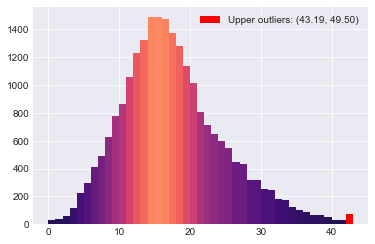

In [119]:
amsterdamumcdb.outliers_histogram(data=apache_ii['apache_ii_total_score']).show()

Add location for easier selection:

In [120]:
apache_ii = pd.merge(apache_ii, admissions[['admissionid','location','urgency']], on='admissionid', how='left')
apache_ii.loc[:,'urgency'] = pd.to_numeric(apache_ii.loc[:,'urgency'])

In [121]:
apache_ii_total = apache_ii.apache_ii_total_score.median()
apache_ii_iqr1_total = apache_ii.apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total = apache_ii.apache_ii_total_score.quantile(0.75)

apache_ii_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

In [122]:
apache_ii_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.median()
apache_ii_iqr1_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.quantile(0.75)

apache_ii_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

In [123]:
apache_ii_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.median()
apache_ii_iqr1_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.quantile(0.75)

apache_ii_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

## Create the actual table in html

In [124]:
display(Markdown("""
<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>{no_patients_total}</td>
            <td>{no_patients_ICU}</td>
            <td>{no_patients_MCU}</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>{no_admissions_total}</td>
            <td>{no_admissions_ICU}</td>
            <td>{no_admissions_MCU}</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>{apache_ii_total_urgent:.0f} [{apache_ii_iqr1_total_urgent:.0f}, {apache_ii_iqr2_total_urgent:.0f}]</td>
            <td>{apache_ii_ICU_urgent:.0f} [{apache_ii_iqr1_ICU_urgent:.0f}, {apache_ii_iqr2_ICU_urgent:.0f}]</td>
            <td>{apache_ii_MCU_urgent:.0f} [{apache_ii_iqr1_MCU_urgent:.0f}, {apache_ii_iqr2_MCU_urgent:.0f}]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>{apache_ii_total_nonurgent:.0f} [{apache_ii_iqr1_total_nonurgent:.0f}, {apache_ii_iqr2_total_nonurgent:.0f}]</td>
            <td>{apache_ii_ICU_nonurgent:.0f} [{apache_ii_iqr1_ICU_nonurgent:.0f}, {apache_ii_iqr2_ICU_nonurgent:.0f}]</td>
            <td>{apache_ii_MCU_nonurgent:.0f} [{apache_ii_iqr1_MCU_nonurgent:.0f}, {apache_ii_iqr2_MCU_nonurgent:.0f}]</td>
        </tr>
    </tbody>
</table>
""".format(
            #No. patients
            no_patients_total = no_patients_total,
            no_patients_ICU = no_patients_ICU,
            no_patients_MCU = no_patients_MCU,

            #No. admissions
            no_admissions_total = no_admissions_total,
            no_admissions_ICU = no_admissions_ICU,
            no_admissions_MCU = no_admissions_MCU,
           
            #Severity scores
            #Urgent
            #APACHE II (Knaus, CCM, 1985)
            apache_ii_total_urgent = apache_ii_total_urgent,
            apache_ii_iqr1_total_urgent = apache_ii_iqr1_total_urgent,
            apache_ii_iqr2_total_urgent = apache_ii_iqr2_total_urgent,

            apache_ii_ICU_urgent = apache_ii_ICU_urgent,
            apache_ii_iqr1_ICU_urgent = apache_ii_iqr1_ICU_urgent,
            apache_ii_iqr2_ICU_urgent = apache_ii_iqr2_ICU_urgent,

            apache_ii_MCU_urgent = apache_ii_MCU_urgent,
            apache_ii_iqr1_MCU_urgent = apache_ii_iqr1_MCU_urgent,
            apache_ii_iqr2_MCU_urgent = apache_ii_iqr2_MCU_urgent,
    
            ## Non-urgent
            #APACHE II (Knaus, CCM, 1985)
            apache_ii_total_nonurgent = apache_ii_total_nonurgent,
            apache_ii_iqr1_total_nonurgent = apache_ii_iqr1_total_nonurgent,
            apache_ii_iqr2_total_nonurgent = apache_ii_iqr2_total_nonurgent,

            apache_ii_ICU_nonurgent = apache_ii_ICU_nonurgent,
            apache_ii_iqr1_ICU_nonurgent = apache_ii_iqr1_ICU_nonurgent,
            apache_ii_iqr2_ICU_nonurgent = apache_ii_iqr2_ICU_nonurgent,

            apache_ii_MCU_nonurgent = apache_ii_MCU_nonurgent,
            apache_ii_iqr1_MCU_nonurgent = apache_ii_iqr1_MCU_nonurgent,
            apache_ii_iqr2_MCU_nonurgent = apache_ii_iqr2_MCU_nonurgent            )
    )
)


<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>20109</td>
            <td>16518</td>
            <td>4295</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>23106</td>
            <td>18386</td>
            <td>4720</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>19 [13, 26]</td>
            <td>21 [16, 27]</td>
            <td>12 [8, 16]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>16 [12, 20]</td>
            <td>17 [14, 21]</td>
            <td>11 [8, 15]</td>
        </tr>
    </tbody>
</table>


In [125]:
#write to csv for re-use
apache_ii.to_csv('apache_ii.csv', index=False)